# Spike distance

In [1]:
from neo.core import SpikeTrain
from quantities import ms
import numpy as np
import pickle
import quantities as pq
from elephant.spike_train_dissimilarity import victor_purpura_distance
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from scipy.special import expit
from scipy.stats import wasserstein_distance
import matplotlib.patches as patches
import h5py
from scipy.signal import convolve
from scipy.interpolate import griddata
import pickle
import pandas as pd
from scipy.stats import ttest_ind
def compute_emd_matrix(spike_trains):
    """
    Compute a pairwise EMD distance matrix for a list of spike trains.
    
    Parameters:
        spike_trains: list of lists, where each sublist is a spike train
    
    Returns:
        emd_matrix: 2D numpy array of shape (N, N) with pairwise EMD values
    """
    num_trials = len(spike_trains)
    emd_matrix = np.zeros((num_trials, num_trials))

    for i in range(num_trials):
        for j in range(i + 1, num_trials):  # Only compute upper triangle
            emd = wasserstein_distance(spike_trains[i], spike_trains[j])
            emd_matrix[i, j] = emd
            emd_matrix[j, i] = emd  # Symmetric matrix

    return emd_matrix

def plot_matrix(matrix, title="Pairwise EMD Distance Matrix"):
    """
    Plots a matrix as a heatmap using Matplotlib.

    Parameters:
        matrix: 2D numpy array to be visualized.
        title: Title of the plot.
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(matrix, cmap="coolwarm", aspect="auto")
    plt.colorbar(label="EMD Distance")
    plt.title(title)
    plt.xlabel("Trial Index")
    plt.ylabel("Trial Index")
    plt.show()
    
def block_means(matrix,n_groups, group_size):
# Initialize an array to store the averaged values.
    block_means = np.zeros((n_groups, n_groups))

    # Loop through each block, compute its mean, and store it.
    for i in range(n_groups):
        for j in range(n_groups):
            
            block = matrix[i*group_size:(i+1)*group_size, j*group_size:(j+1)*group_size]
            # Compute the average of the block.
            block_means[i, j] = block.mean()
    return block_means

def block_stats_all(matrix, n_real):


    real_real   = matrix[:n_real,   :n_real].ravel()
    real_model  = matrix[:n_real,   n_real:].ravel()
    model_model = matrix[n_real:, n_real:].ravel() 
    stats = []
    for label, block in zip(["Real–Real", "Real–Model", "Model–Model"],
                              [real_real, real_model, model_model]):
        mean_val = block.mean()
        range_val = block.max() - block.min()
        std_val = block.std()
        cv_val = std_val / mean_val if mean_val != 0 else 0
        # stats.append([label, f"{mean_val:.2f}", f"{range_val:.2f}", f"{std_val:.2f}", f"{cv_val:.2f}"])
        stats.append({
            "label": label,
            "mean":  mean_val,
            "range": range_val,
            "std":   std_val,
            "cv":    cv_val,
            "data":  block
        })

    # now compute pairwise p–values (t–test) vs. Real–Real
    base = stats[0]["data"]   # Real–Real
    for entry in stats:
        tstat, pval = ttest_ind(base, entry["data"], equal_var=False)
        entry["p"] = float(pval)

    # build the cell text to draw
    table  = []
    for entry in stats:
        table.append([
            entry["label"],
            f"{entry['mean']:.2f}",
            f"{entry['range']:.2f}",
            f"{entry['std']:.2f}",
            f"{entry['cv']:.2f}",
            f"{entry['p']:.7f}"
        ])
    return table

def plot_matrixcat_and_stats(matrix, title="Pairwise EMD Distance Matrix", n_real=None, n_model=None, group_size=None):

    # Total number of trials (columns)
    N = matrix.shape[1]
    if n_real is None or n_model is None:
        n_real = N // 2
        n_model = N - n_real

    # Create the main heatmap with colorbar.
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(matrix, cmap="coolwarm", aspect="auto")
    ax.set_xlabel("Trial Index")
    ax.set_ylabel("Trial Index")
    ax.set_title(title, fontsize=20, pad=40)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="EMD Distance")

    # Get the position of the heatmap axis.
    pos = ax.get_position()
    gap_val = 0.005         # Vertical gap between the heatmap and the category bar.
    cat_bar_height = 0.03     # Height of the category bar.

    # Create a new axis above the heatmap for the category bar.
    cat_ax = fig.add_axes([pos.x0, pos.y0 + pos.height + gap_val, pos.width, cat_bar_height])
    cat_ax.set_xlim(0, N)
    cat_ax.set_ylim(0, 1)
    cat_ax.axis("off")

    # Define a gap (in trial units) between the two black bars.
    gap = 2  
    real_width = n_real - gap / 2
    model_width = n_model - gap / 2

    # Draw the "Real" bar (black) covering the real trials.
    cat_ax.add_patch(patches.Rectangle((0, 0), real_width, 0.21, facecolor="black"))
    # Draw the "Model" bar (black) covering the model trials.
    cat_ax.add_patch(patches.Rectangle((n_real + gap/2, 0), model_width, 0.21, facecolor="black"))

    # Add text labels over each bar.
    cat_ax.text(real_width / 2, 0.5, "Real", ha="center", va="bottom", fontsize=20, fontweight="bold", color="black")
    cat_ax.text(n_real + gap/2 + model_width / 2, 0.5, "Model", ha="center", va="bottom", fontsize=20, fontweight="bold", color="black")

    # Create an axis for the statistics table below the heatmap.
    table_height = 0.15  # Adjust table height as needed.
    table_ax = fig.add_axes([pos.x0, pos.y0 - table_height - 0.2, pos.width, table_height])
    table_ax.axis('off')
    
    # Compute block statistics for three blocks.
    stats = block_stats_all(matrix, n_real)
    column_labels = ["Block", "Mean", "Range", "Std", "CV","p-value"]
    cell_text = stats  # Each row: [Block, Mean, Range, Std, CV]
    
    table = table_ax.table(cellText=cell_text, colLabels=column_labels, loc='center', cellLoc='center')
    table.auto_set_font_size(True)
    # table.set_fontsize(14)
    table.scale(1, 1.2)
    table_ax.set_title("Block Statistics", fontsize=20, pad=20)
    
    plt.show()






def generate_stimuli(trajx, trajy,board_size=400, diameter=30,fps = 60,pretime = 50,tailtime =50,type='natural',preframes=15,tailframes=45,stimframes=15):
    stimuli = []
    dt = 1/fps

    board_range = [-(board_size/2), (board_size/2)]  
    radius = diameter / 2  

    x_vals = np.linspace(board_range[0], board_range[1], board_size+1)
    y_vals = np.linspace(board_range[0], board_range[1], board_size+1)
    X, Y = np.meshgrid(x_vals, y_vals)
    
    if type == 'natural':
        if len(trajx) != len(trajy):
            raise ValueError("trajx and trajy must have the same length.")
        if len(trajx) == 0:
            raise ValueError("Trajectory arrays must not be empty.")

        preframenum = int(pretime / 1000 /dt)
        tailframenum = int(tailtime / 1000 /dt)
        for _ in range(preframenum):
            frame = np.zeros((board_size+1, board_size+1), dtype=np.uint8)
            stimuli.append(frame)   
        
        for frame_idx, (x, y) in enumerate(zip(trajx, trajy)):
            # if frame_idx < preframenum or frame_idx >= (len(trajx) - tailframenum):
            #     # Draw blank
            #     frame = np.zeros((board_size, board_size), dtype=np.uint8)
            # else:
                # Draw the circle
            frame = np.zeros((board_size+1, board_size+1), dtype=np.uint8)
            mask = (X - x) ** 2 + (Y - y) ** 2 <= radius ** 2
            frame[mask] = 1

            stimuli.append(frame)   
            
        for _ in range(tailframenum):
            frame = np.zeros((board_size+1, board_size+1), dtype=np.uint8)
            stimuli.append(frame)   
    if type == 'spotfield':
        if len(trajx) != len(trajy):
            raise ValueError("trajx and trajy must have the same length.")
        if len(trajx) == 0:
            raise ValueError("Trajectory arrays must not be empty.")

    
        for section_idx, (x, y) in enumerate(zip(trajx, trajy)):
            frame = np.zeros((board_size+1, board_size+1), dtype=np.uint8)
            for _ in range(preframes):
                stimuli.append(frame)   
                
            frame = np.zeros((board_size+1, board_size+1), dtype=np.uint8)
            mask = (X - x) ** 2 + (Y - y) ** 2 <= radius ** 2
            frame[mask] = 1
            for _ in range(stimframes):
                stimuli.append(frame)   
            frame = np.zeros((board_size+1, board_size+1), dtype=np.uint8)
            for _ in range(tailframes):
                stimuli.append(frame)   
        
    return np.array(stimuli)


def spatial_filterSF(rf,A=0.2):
    return A * rf

def gaussian_2d(x, y, sigma_x, sigma_y, A=1, x0=0, y0=0):
    X, Y = np.meshgrid(x, y, indexing='ij')
    return A * np.exp(-((X - x0)**2 / (2 * sigma_x**2) + (Y - y0)**2 / (2 * sigma_y**2)))

def gaussian_2dflatten(x, y, sigma_x, sigma_y,mix, widenratio, A=1, x0=0, y0=0):
    A = gaussian_2d(x=x, y=y, sigma_x = sigma_x, sigma_y = sigma_y, A=A, x0=x0, y0=y0) + gaussian_2d(x=x, y=y, sigma_x = widenratio* sigma_x, sigma_y = widenratio*sigma_y, A=mix*A, x0=x0, y0=y0)
    A = A / np.max(A)
    return A 

def difference_of_gaussians(x, y, sigma_c, sigma_s, A_c=0.4, A_s=0.2):
    X, Y = np.meshgrid(x, y, indexing='ij')
    center = A_c * np.exp(-(X**2 + Y**2) / (2 * sigma_c**2))
    surround = A_s * np.exp(-(X**2 + Y**2) / (2 * sigma_s**2))
    return center - surround
def generalized_gaussian_2d(x, y, sigma_x, sigma_y, alpha, A=1.0, x0=0, y0=0):
    """
    2D generalized Gaussian with exponent alpha:
    - alpha = 1: standard Gaussian
    - 0 < alpha < 1: heavier tails (higher kurtosis)
    - alpha > 1: lighter tails
    """
    X, Y = np.meshgrid(x, y, indexing='ij')
    Q = ((X - x0)**2 / (2 * sigma_x**2) +
         (Y - y0)**2 / (2 * sigma_y**2))
    d = A * np.exp(- Q**alpha)
    d = d / d[int((len(x)-1)/2),int((len(x)-1)/2+1)]
    return d   # Normalize to max value of 1

# 2) Student's-t / Cauchy-style kernel
def student_t_2d(x, y, sigma_x, sigma_y, nu, A=1.0, x0=0, y0=0):
    """
    2D Student's-t distribution (heavy-tailed):
    - nu: degrees of freedom. Lower nu -> heavier tails
    - For nu=1: Cauchy (Lorentzian) form
    """
    X, Y = np.meshgrid(x, y, indexing='ij')
    r2 = ((X - x0)**2 / sigma_x**2 + (Y - y0)**2 / sigma_y**2)
    return A * (1 + r2 / nu) ** (-(nu + 1) / 2)
def biphasic_temporal_filter(t, p1, p2, tau1, tau2, n):
    t = np.asarray(-t, dtype=float)
    term1 = p1 * (t / tau1)**n * np.exp(-n * (t / tau1 - 1))
    term2 = p2 * (t / tau2)**n * np.exp(-n * (t / tau2 - 1))
    return term1 - term2

def apply_temporal_filter_to_movie(movie, temporal_filter):

    F, = movie.shape  
    T = len(temporal_filter) 

    filtered_movie = np.zeros_like(movie)

    filtered_signal = convolve(movie, temporal_filter, mode='full')[:F]
    
    filtered_movie[:] = filtered_signal

    return filtered_movie

def linear_filter(spatial_rf, noise_input, temporal_filter):   

    T, Y, X = noise_input.shape 
    # x = np.linspace(-(X-1)/2, (X-1)/2, X)
    # y = np.linspace(-(Y-1)/2, (Y-1)/2, Y)
    noise_input = noise_input.astype(np.float32)
    
    # if type == 'gaussian':
    #     spatial_rf = gaussian_2d(x, y, sigma_x, sigma_y, A, x0=0, y0=0) # Shape: (Y,X)
    # if type == 'difference_of_gaussians':
    #     spatial_rf = difference_of_gaussians(x, y, sigma_c, sigma_s, A_c, A_s)  # Shape: (Y,X)
    # if type == 'SFfitting':
    #     spatial_rf = spatial_filterSF(rf=rf_estimated,A=A)
    # if type == 'gaussian_2dflatten':
    #     spatial_rf = gaussian_2dflatten(x, y, sigma_x, sigma_y, mix, widenratio, A, x0=0, y0=0)  # Shape: (Y,X)
    spatial_rf = spatial_rf.astype(np.float32)   
    spatial_filtered_movie = noise_input.reshape((T,Y*X)) @ spatial_rf.reshape((Y*X))  # Shape: (T,)
    filtered_movie = apply_temporal_filter_to_movie(spatial_filtered_movie, temporal_filter)

    return filtered_movie

def apply_nonlinearity(linear_output, method='static', **kwargs):
    if method == 'static':
        return np.maximum(0, linear_output)
    elif method == 'sigmoid':
        gain = kwargs.get('gain', 0.02)
        max_rate = kwargs.get('max_rate', 250.0)
        C = kwargs.get('y', -30)
        return max_rate * expit(gain * (linear_output + C))
    elif method == 'sigmoidgc':
        gain = kwargs.get('gain', 0.05)
        max_rate = kwargs.get('max_rate', 1500.0)
        C = kwargs.get('y', -37256.659)
        return max_rate / (0.04 + np.exp(-gain * (linear_output+165)))  + C
    elif method == 'threshold_linear':
        theta = kwargs.get('theta', 10)
        return np.maximum(0, linear_output - theta)
    elif method == 'threshold_lineargc':
        theta = kwargs.get('theta', 0)
        return np.maximum(0, linear_output - theta)
    elif method == 'powerlaw':
        gamma = kwargs.get('gamma', 0.5)
        return np.maximum(0, np.abs(linear_output)**gamma)
    elif method == 'exponential_saturation':
        alpha = kwargs.get('alpha', 0.1)
        beta = kwargs.get('beta', 1.0)
        return beta * (1 - np.exp(-alpha * linear_output))
    elif method == 'adaptive_gain':
        gain = kwargs.get('gain', 1.0)
        return gain * np.maximum(0, linear_output)
    else:
        raise ValueError("Unknown nonlinearity method")
    



# Gain control definition
def resample_and_generate_spikes(firing_rates, target_time_bin=1/1200):


    original_time_bin = 1 / 60

    upsampling_factor = int(original_time_bin / target_time_bin)
    if upsampling_factor < 1:
        raise ValueError("Target time bin must be smaller")

    expanded_firing_rates = np.repeat(firing_rates, upsampling_factor, axis=0)


    scaled_rates = expanded_firing_rates * target_time_bin


    spikes = np.random.poisson(scaled_rates)

    return spikes

def gain_control(Lout, B=0.005, tau=11.0):

    T = len(Lout)  
    v_t = np.zeros(T)  
    g_v = np.zeros(T)
    gain_controlled_Lout = np.zeros(T) 
    gain_controlled_Lout[0] = 1 * Lout[0]
    decay_kernel = B * np.exp(-np.arange(T) / tau)

    for t in range(T):
        v_t[t] = np.sum(gain_controlled_Lout[:t] * decay_kernel[:t][::-1]) 
        g_v[t] = 1 if v_t[t] < 0 else 1 / (1 + v_t[t]**4)
        gain_controlled_Lout[t] = g_v[t] * Lout[t]

    return gain_controlled_Lout, g_v


rf_estimated = np.load('rf_estimated.npy')
with open('spike_trainGC.pkl', 'rb') as f:
    spike_trainGC = pickle.load(f)


with open('spike_indices_n.pkl', 'rb') as f:
    spike_indices_n = pickle.load(f)

with open('spike_indices_c.pkl', 'rb') as f:
    spike_indices_c = pickle.load(f)



spike_indicesModified_n = spike_indices_n.copy()
spike_indicesModified_c = spike_indices_c.copy()
spike_indicesModified_n[4] = spike_indices_n[4]-800
spike_indicesModified_n[45] = spike_indices_n[45]-800
spike_indicesModified_c[34] = spike_indices_c[34]-800

In [2]:
from neo.core import SpikeTrain
from quantities import ms
import numpy as np
import pickle
import quantities as pq
from elephant.spike_train_dissimilarity import victor_purpura_distance
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from scipy.special import expit
from scipy.stats import wasserstein_distance
import matplotlib.patches as patches
import h5py
from scipy.signal import convolve
from scipy.interpolate import griddata
import pickle
import pandas as pd
from scipy.stats import ttest_ind
def compute_emd_matrix(spike_trains):
    """
    Compute a pairwise EMD distance matrix for a list of spike trains.
    
    Parameters:
        spike_trains: list of lists, where each sublist is a spike train
    
    Returns:
        emd_matrix: 2D numpy array of shape (N, N) with pairwise EMD values
    """
    num_trials = len(spike_trains)
    emd_matrix = np.zeros((num_trials, num_trials))

    for i in range(num_trials):
        for j in range(i + 1, num_trials):  # Only compute upper triangle
            emd = wasserstein_distance(spike_trains[i], spike_trains[j])
            emd_matrix[i, j] = emd
            emd_matrix[j, i] = emd  # Symmetric matrix

    return emd_matrix

def plot_matrix(matrix, title="Pairwise EMD Distance Matrix"):
    """
    Plots a matrix as a heatmap using Matplotlib.

    Parameters:
        matrix: 2D numpy array to be visualized.
        title: Title of the plot.
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(matrix, cmap="coolwarm", aspect="auto")
    plt.colorbar(label="EMD Distance")
    plt.title(title)
    plt.xlabel("Trial Index")
    plt.ylabel("Trial Index")
    plt.show()
    
def block_means(matrix,n_groups, group_size):
# Initialize an array to store the averaged values.
    block_means = np.zeros((n_groups, n_groups))

    # Loop through each block, compute its mean, and store it.
    for i in range(n_groups):
        for j in range(n_groups):
            
            block = matrix[i*group_size:(i+1)*group_size, j*group_size:(j+1)*group_size]
            # Compute the average of the block.
            block_means[i, j] = block.mean()
    return block_means

def block_stats_all(matrix, n_real):


    real_real   = matrix[:n_real,   :n_real].ravel()
    real_model  = matrix[:n_real,   n_real:].ravel()
    model_model = matrix[n_real:, n_real:].ravel() 
    stats = []
    for label, block in zip(["Real–Real", "Real–Model", "Model–Model"],
                              [real_real, real_model, model_model]):
        mean_val = block.mean()
        range_val = block.max() - block.min()
        std_val = block.std()
        cv_val = std_val / mean_val if mean_val != 0 else 0
        # stats.append([label, f"{mean_val:.2f}", f"{range_val:.2f}", f"{std_val:.2f}", f"{cv_val:.2f}"])
        stats.append({
            "label": label,
            "mean":  mean_val,
            "range": range_val,
            "std":   std_val,
            "cv":    cv_val,
            "data":  block
        })

    # now compute pairwise p–values (t–test) vs. Real–Real
    base = stats[0]["data"]   # Real–Real
    for entry in stats:
        tstat, pval = ttest_ind(base, entry["data"], equal_var=False)
        entry["p"] = float(pval)

    # build the cell text to draw
    table  = []
    for entry in stats:
        table.append([
            entry["label"],
            f"{entry['mean']:.2f}",
            f"{entry['range']:.2f}",
            f"{entry['std']:.2f}",
            f"{entry['cv']:.2f}",
            f"{entry['p']:.7f}"
        ])
    return table

def plot_matrixcat_and_stats(matrix, title="Pairwise EMD Distance Matrix", n_real=None, n_model=None, group_size=None):

    # Total number of trials (columns)
    N = matrix.shape[1]
    if n_real is None or n_model is None:
        n_real = N // 2
        n_model = N - n_real

    # Create the main heatmap with colorbar.
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(matrix, cmap="coolwarm", aspect="auto")
    ax.set_xlabel("Trial Index")
    ax.set_ylabel("Trial Index")
    ax.set_title(title, fontsize=20, pad=40)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="EMD Distance")

    # Get the position of the heatmap axis.
    pos = ax.get_position()
    gap_val = 0.005         # Vertical gap between the heatmap and the category bar.
    cat_bar_height = 0.03     # Height of the category bar.

    # Create a new axis above the heatmap for the category bar.
    cat_ax = fig.add_axes([pos.x0, pos.y0 + pos.height + gap_val, pos.width, cat_bar_height])
    cat_ax.set_xlim(0, N)
    cat_ax.set_ylim(0, 1)
    cat_ax.axis("off")

    # Define a gap (in trial units) between the two black bars.
    gap = 2  
    real_width = n_real - gap / 2
    model_width = n_model - gap / 2

    # Draw the "Real" bar (black) covering the real trials.
    cat_ax.add_patch(patches.Rectangle((0, 0), real_width, 0.21, facecolor="black"))
    # Draw the "Model" bar (black) covering the model trials.
    cat_ax.add_patch(patches.Rectangle((n_real + gap/2, 0), model_width, 0.21, facecolor="black"))

    # Add text labels over each bar.
    cat_ax.text(real_width / 2, 0.5, "Real", ha="center", va="bottom", fontsize=20, fontweight="bold", color="black")
    cat_ax.text(n_real + gap/2 + model_width / 2, 0.5, "Model", ha="center", va="bottom", fontsize=20, fontweight="bold", color="black")

    # Create an axis for the statistics table below the heatmap.
    table_height = 0.15  # Adjust table height as needed.
    table_ax = fig.add_axes([pos.x0, pos.y0 - table_height - 0.2, pos.width, table_height])
    table_ax.axis('off')
    
    # Compute block statistics for three blocks.
    stats = block_stats_all(matrix, n_real)
    column_labels = ["Block", "Mean", "Range", "Std", "CV","p-value"]
    cell_text = stats  # Each row: [Block, Mean, Range, Std, CV]
    
    table = table_ax.table(cellText=cell_text, colLabels=column_labels, loc='center', cellLoc='center')
    table.auto_set_font_size(True)
    # table.set_fontsize(14)
    table.scale(1, 1.2)
    table_ax.set_title("Block Statistics", fontsize=20, pad=20)
    
    plt.show()






def generate_stimuli(trajx, trajy,board_size=400, diameter=30,fps = 60,pretime = 50,tailtime =50,type='natural',preframes=15,tailframes=45,stimframes=15):
    stimuli = []
    dt = 1/fps

    board_range = [-(board_size/2), (board_size/2)]  
    radius = diameter / 2  

    x_vals = np.linspace(board_range[0], board_range[1], board_size+1)
    y_vals = np.linspace(board_range[0], board_range[1], board_size+1)
    X, Y = np.meshgrid(x_vals, y_vals)
    
    if type == 'natural':
        if len(trajx) != len(trajy):
            raise ValueError("trajx and trajy must have the same length.")
        if len(trajx) == 0:
            raise ValueError("Trajectory arrays must not be empty.")

        preframenum = int(pretime / 1000 /dt)
        tailframenum = int(tailtime / 1000 /dt)
        for _ in range(preframenum):
            frame = np.zeros((board_size+1, board_size+1), dtype=np.uint8)
            stimuli.append(frame)   
        
        for frame_idx, (x, y) in enumerate(zip(trajx, trajy)):
            # if frame_idx < preframenum or frame_idx >= (len(trajx) - tailframenum):
            #     # Draw blank
            #     frame = np.zeros((board_size, board_size), dtype=np.uint8)
            # else:
                # Draw the circle
            frame = np.zeros((board_size+1, board_size+1), dtype=np.uint8)
            mask = (X - x) ** 2 + (Y - y) ** 2 <= radius ** 2
            frame[mask] = 1

            stimuli.append(frame)   
            
        for _ in range(tailframenum):
            frame = np.zeros((board_size+1, board_size+1), dtype=np.uint8)
            stimuli.append(frame)   
    if type == 'spotfield':
        if len(trajx) != len(trajy):
            raise ValueError("trajx and trajy must have the same length.")
        if len(trajx) == 0:
            raise ValueError("Trajectory arrays must not be empty.")

    
        for section_idx, (x, y) in enumerate(zip(trajx, trajy)):
            frame = np.zeros((board_size+1, board_size+1), dtype=np.uint8)
            for _ in range(preframes):
                stimuli.append(frame)   
                
            frame = np.zeros((board_size+1, board_size+1), dtype=np.uint8)
            mask = (X - x) ** 2 + (Y - y) ** 2 <= radius ** 2
            frame[mask] = 1
            for _ in range(stimframes):
                stimuli.append(frame)   
            frame = np.zeros((board_size+1, board_size+1), dtype=np.uint8)
            for _ in range(tailframes):
                stimuli.append(frame)   
        
    return np.array(stimuli)


def spatial_filterSF(rf,A=0.2):
    return A * rf

def gaussian_2d(x, y, sigma_x, sigma_y, A=1, x0=0, y0=0):
    X, Y = np.meshgrid(x, y, indexing='ij')
    return A * np.exp(-((X - x0)**2 / (2 * sigma_x**2) + (Y - y0)**2 / (2 * sigma_y**2)))

def gaussian_2dflatten(x, y, sigma_x, sigma_y,mix, widenratio, A=1, x0=0, y0=0):
    A = gaussian_2d(x=x, y=y, sigma_x = sigma_x, sigma_y = sigma_y, A=A, x0=x0, y0=y0) + gaussian_2d(x=x, y=y, sigma_x = widenratio* sigma_x, sigma_y = widenratio*sigma_y, A=mix*A, x0=x0, y0=y0)
    A = A / np.max(A)
    return A 

def difference_of_gaussians(x, y, sigma_c, sigma_s, A_c=0.4, A_s=0.2):
    X, Y = np.meshgrid(x, y, indexing='ij')
    center = A_c * np.exp(-(X**2 + Y**2) / (2 * sigma_c**2))
    surround = A_s * np.exp(-(X**2 + Y**2) / (2 * sigma_s**2))
    return center - surround
def generalized_gaussian_2d(x, y, sigma_x, sigma_y, alpha, A=1.0, x0=0, y0=0):
    """
    2D generalized Gaussian with exponent alpha:
    - alpha = 1: standard Gaussian
    - 0 < alpha < 1: heavier tails (higher kurtosis)
    - alpha > 1: lighter tails
    """
    X, Y = np.meshgrid(x, y, indexing='ij')
    Q = ((X - x0)**2 / (2 * sigma_x**2) +
         (Y - y0)**2 / (2 * sigma_y**2))
    d = A * np.exp(- Q**alpha)
    d = d / d[int((len(x)-1)/2),int((len(x)-1)/2+1)]
    return d   # Normalize to max value of 1

# 2) Student's-t / Cauchy-style kernel
def student_t_2d(x, y, sigma_x, sigma_y, nu, A=1.0, x0=0, y0=0):
    """
    2D Student's-t distribution (heavy-tailed):
    - nu: degrees of freedom. Lower nu -> heavier tails
    - For nu=1: Cauchy (Lorentzian) form
    """
    X, Y = np.meshgrid(x, y, indexing='ij')
    r2 = ((X - x0)**2 / sigma_x**2 + (Y - y0)**2 / sigma_y**2)
    return A * (1 + r2 / nu) ** (-(nu + 1) / 2)
def biphasic_temporal_filter(t, p1, p2, tau1, tau2, n):
    t = np.asarray(-t, dtype=float)
    term1 = p1 * (t / tau1)**n * np.exp(-n * (t / tau1 - 1))
    term2 = p2 * (t / tau2)**n * np.exp(-n * (t / tau2 - 1))
    return term1 - term2

def apply_temporal_filter_to_movie(movie, temporal_filter):

    F, = movie.shape  
    T = len(temporal_filter) 

    filtered_movie = np.zeros_like(movie)

    filtered_signal = convolve(movie, temporal_filter, mode='full')[:F]
    
    filtered_movie[:] = filtered_signal

    return filtered_movie

def linear_filter(spatial_rf, noise_input, temporal_filter):   

    T, Y, X = noise_input.shape 
    # x = np.linspace(-(X-1)/2, (X-1)/2, X)
    # y = np.linspace(-(Y-1)/2, (Y-1)/2, Y)
    noise_input = noise_input.astype(np.float32)
    
    # if type == 'gaussian':
    #     spatial_rf = gaussian_2d(x, y, sigma_x, sigma_y, A, x0=0, y0=0) # Shape: (Y,X)
    # if type == 'difference_of_gaussians':
    #     spatial_rf = difference_of_gaussians(x, y, sigma_c, sigma_s, A_c, A_s)  # Shape: (Y,X)
    # if type == 'SFfitting':
    #     spatial_rf = spatial_filterSF(rf=rf_estimated,A=A)
    # if type == 'gaussian_2dflatten':
    #     spatial_rf = gaussian_2dflatten(x, y, sigma_x, sigma_y, mix, widenratio, A, x0=0, y0=0)  # Shape: (Y,X)
    spatial_rf = spatial_rf.astype(np.float32)   
    spatial_filtered_movie = noise_input.reshape((T,Y*X)) @ spatial_rf.reshape((Y*X))  # Shape: (T,)
    filtered_movie = apply_temporal_filter_to_movie(spatial_filtered_movie, temporal_filter)

    return filtered_movie

def apply_nonlinearity(linear_output, method='static', **kwargs):
    if method == 'static':
        return np.maximum(0, linear_output)
    elif method == 'sigmoid':
        gain = kwargs.get('gain', 0.02)
        max_rate = kwargs.get('max_rate', 250.0)
        C = kwargs.get('y', -30)
        return max_rate * expit(gain * (linear_output + C))
    elif method == 'sigmoidgc':
        gain = kwargs.get('gain', 0.05)
        max_rate = kwargs.get('max_rate', 1500.0)
        C = kwargs.get('y', -37256.659)
        return max_rate / (0.04 + np.exp(-gain * (linear_output+165)))  + C
    elif method == 'threshold_linear':
        theta = kwargs.get('theta', 10)
        return np.maximum(0, linear_output - theta)
    elif method == 'threshold_lineargc':
        theta = kwargs.get('theta', 0)
        return np.maximum(0, linear_output - theta)
    elif method == 'powerlaw':
        gamma = kwargs.get('gamma', 0.5)
        return np.maximum(0, np.abs(linear_output)**gamma)
    elif method == 'exponential_saturation':
        alpha = kwargs.get('alpha', 0.1)
        beta = kwargs.get('beta', 1.0)
        return beta * (1 - np.exp(-alpha * linear_output))
    elif method == 'adaptive_gain':
        gain = kwargs.get('gain', 1.0)
        return gain * np.maximum(0, linear_output)
    else:
        raise ValueError("Unknown nonlinearity method")
    



# Gain control definition
def resample_and_generate_spikes(firing_rates, target_time_bin=1/1200):


    original_time_bin = 1 / 60

    upsampling_factor = int(original_time_bin / target_time_bin)
    if upsampling_factor < 1:
        raise ValueError("Target time bin must be smaller")

    expanded_firing_rates = np.repeat(firing_rates, upsampling_factor, axis=0)


    scaled_rates = expanded_firing_rates * target_time_bin


    spikes = np.random.poisson(scaled_rates)

    return spikes

def gain_control(Lout, B=0.005, tau=11.0):

    T = len(Lout)  
    v_t = np.zeros(T)  
    g_v = np.zeros(T)
    gain_controlled_Lout = np.zeros(T) 
    gain_controlled_Lout[0] = 1 * Lout[0]
    decay_kernel = B * np.exp(-np.arange(T) / tau)

    for t in range(T):
        v_t[t] = np.sum(gain_controlled_Lout[:t] * decay_kernel[:t][::-1]) 
        g_v[t] = 1 if v_t[t] < 0 else 1 / (1 + v_t[t]**4)
        gain_controlled_Lout[t] = g_v[t] * Lout[t]

    return gain_controlled_Lout, g_v


rf_estimated = np.load('rf_estimated.npy')
with open('spike_trainGC.pkl', 'rb') as f:
    spike_trainGC = pickle.load(f)


with open('spike_indices_n.pkl', 'rb') as f:
    spike_indices_n = pickle.load(f)

with open('spike_indices_c.pkl', 'rb') as f:
    spike_indices_c = pickle.load(f)



spike_indicesModified_n = spike_indices_n.copy()
spike_indicesModified_c = spike_indices_c.copy()
spike_indicesModified_n[4] = spike_indices_n[4]-800
spike_indicesModified_n[45] = spike_indices_n[45]-800
spike_indicesModified_c[34] = spike_indices_c[34]-800

In [3]:
from neo.core import SpikeTrain
from quantities import ms
import numpy as np
import pickle
import quantities as pq
from elephant.spike_train_dissimilarity import victor_purpura_distance
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from scipy.special import expit
from scipy.stats import wasserstein_distance
import matplotlib.patches as patches
import h5py
from scipy.signal import convolve
from scipy.interpolate import griddata
import pickle
import pandas as pd
from scipy.stats import ttest_ind
def compute_emd_matrix(spike_trains):
    """
    Compute a pairwise EMD distance matrix for a list of spike trains.
    
    Parameters:
        spike_trains: list of lists, where each sublist is a spike train
    
    Returns:
        emd_matrix: 2D numpy array of shape (N, N) with pairwise EMD values
    """
    num_trials = len(spike_trains)
    emd_matrix = np.zeros((num_trials, num_trials))

    for i in range(num_trials):
        for j in range(i + 1, num_trials):  # Only compute upper triangle
            emd = wasserstein_distance(spike_trains[i], spike_trains[j])
            emd_matrix[i, j] = emd
            emd_matrix[j, i] = emd  # Symmetric matrix

    return emd_matrix

def plot_matrix(matrix, title="Pairwise EMD Distance Matrix"):
    """
    Plots a matrix as a heatmap using Matplotlib.

    Parameters:
        matrix: 2D numpy array to be visualized.
        title: Title of the plot.
    """
    plt.figure(figsize=(10, 8))
    plt.imshow(matrix, cmap="coolwarm", aspect="auto")
    plt.colorbar(label="EMD Distance")
    plt.title(title)
    plt.xlabel("Trial Index")
    plt.ylabel("Trial Index")
    plt.show()
    
def block_means(matrix,n_groups, group_size):
# Initialize an array to store the averaged values.
    block_means = np.zeros((n_groups, n_groups))

    # Loop through each block, compute its mean, and store it.
    for i in range(n_groups):
        for j in range(n_groups):
            
            block = matrix[i*group_size:(i+1)*group_size, j*group_size:(j+1)*group_size]
            # Compute the average of the block.
            block_means[i, j] = block.mean()
    return block_means

def block_stats_all(matrix, n_real):


    real_real   = matrix[:n_real,   :n_real].ravel()
    real_model  = matrix[:n_real,   n_real:].ravel()
    model_model = matrix[n_real:, n_real:].ravel() 
    stats = []
    for label, block in zip(["Real–Real", "Real–Model", "Model–Model"],
                              [real_real, real_model, model_model]):
        mean_val = block.mean()
        range_val = block.max() - block.min()
        std_val = block.std()
        cv_val = std_val / mean_val if mean_val != 0 else 0
        # stats.append([label, f"{mean_val:.2f}", f"{range_val:.2f}", f"{std_val:.2f}", f"{cv_val:.2f}"])
        stats.append({
            "label": label,
            "mean":  mean_val,
            "range": range_val,
            "std":   std_val,
            "cv":    cv_val,
            "data":  block
        })

    # now compute pairwise p–values (t–test) vs. Real–Real
    base = stats[0]["data"]   # Real–Real
    for entry in stats:
        tstat, pval = ttest_ind(base, entry["data"], equal_var=False)
        entry["p"] = float(pval)

    # build the cell text to draw
    table  = []
    for entry in stats:
        table.append([
            entry["label"],
            f"{entry['mean']:.2f}",
            f"{entry['range']:.2f}",
            f"{entry['std']:.2f}",
            f"{entry['cv']:.2f}",
            f"{entry['p']:.7f}"
        ])
    return table,stats

def plot_matrixcat_and_stats(matrix, title="Pairwise EMD Distance Matrix", n_real=None, n_model=None, group_size=None):

    # Total number of trials (columns)
    N = matrix.shape[1]
    if n_real is None or n_model is None:
        n_real = N // 2
        n_model = N - n_real

    # Create the main heatmap with colorbar.
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(matrix, cmap="coolwarm", aspect="auto")
    ax.set_xlabel("Trial Index")
    ax.set_ylabel("Trial Index")
    ax.set_title(title, fontsize=20, pad=40)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="EMD Distance")

    # Get the position of the heatmap axis.
    pos = ax.get_position()
    gap_val = 0.005         # Vertical gap between the heatmap and the category bar.
    cat_bar_height = 0.03     # Height of the category bar.

    # Create a new axis above the heatmap for the category bar.
    cat_ax = fig.add_axes([pos.x0, pos.y0 + pos.height + gap_val, pos.width, cat_bar_height])
    cat_ax.set_xlim(0, N)
    cat_ax.set_ylim(0, 1)
    cat_ax.axis("off")

    # Define a gap (in trial units) between the two black bars.
    gap = 2  
    real_width = n_real - gap / 2
    model_width = n_model - gap / 2

    # Draw the "Real" bar (black) covering the real trials.
    cat_ax.add_patch(patches.Rectangle((0, 0), real_width, 0.21, facecolor="black"))
    # Draw the "Model" bar (black) covering the model trials.
    cat_ax.add_patch(patches.Rectangle((n_real + gap/2, 0), model_width, 0.21, facecolor="black"))

    # Add text labels over each bar.
    cat_ax.text(real_width / 2, 0.5, "Real", ha="center", va="bottom", fontsize=20, fontweight="bold", color="black")
    cat_ax.text(n_real + gap/2 + model_width / 2, 0.5, "Model", ha="center", va="bottom", fontsize=20, fontweight="bold", color="black")

    # Create an axis for the statistics table below the heatmap.
    table_height = 0.15  # Adjust table height as needed.
    table_ax = fig.add_axes([pos.x0, pos.y0 - table_height - 0.2, pos.width, table_height])
    table_ax.axis('off')
    
    # Compute block statistics for three blocks.
    stats,_ = block_stats_all(matrix, n_real)
    column_labels = ["Block", "Mean", "Range", "Std", "CV","p-value"]
    cell_text = stats  # Each row: [Block, Mean, Range, Std, CV]
    
    table = table_ax.table(cellText=cell_text, colLabels=column_labels, loc='center', cellLoc='center')
    table.auto_set_font_size(True)
    # table.set_fontsize(14)
    table.scale(1, 1.2)
    table_ax.set_title("Block Statistics", fontsize=20, pad=20)
    
    plt.show()






def generate_stimuli(trajx, trajy,board_size=400, diameter=30,fps = 60,pretime = 50,tailtime =50,type='natural',preframes=15,tailframes=45,stimframes=15):
    stimuli = []
    dt = 1/fps

    board_range = [-(board_size/2), (board_size/2)]  
    radius = diameter / 2  

    x_vals = np.linspace(board_range[0], board_range[1], board_size+1)
    y_vals = np.linspace(board_range[0], board_range[1], board_size+1)
    X, Y = np.meshgrid(x_vals, y_vals)
    
    if type == 'natural':
        if len(trajx) != len(trajy):
            raise ValueError("trajx and trajy must have the same length.")
        if len(trajx) == 0:
            raise ValueError("Trajectory arrays must not be empty.")

        preframenum = int(pretime / 1000 /dt)
        tailframenum = int(tailtime / 1000 /dt)
        for _ in range(preframenum):
            frame = np.zeros((board_size+1, board_size+1), dtype=np.uint8)
            stimuli.append(frame)   
        
        for frame_idx, (x, y) in enumerate(zip(trajx, trajy)):
            # if frame_idx < preframenum or frame_idx >= (len(trajx) - tailframenum):
            #     # Draw blank
            #     frame = np.zeros((board_size, board_size), dtype=np.uint8)
            # else:
                # Draw the circle
            frame = np.zeros((board_size+1, board_size+1), dtype=np.uint8)
            mask = (X - x) ** 2 + (Y - y) ** 2 <= radius ** 2
            frame[mask] = 1

            stimuli.append(frame)   
            
        for _ in range(tailframenum):
            frame = np.zeros((board_size+1, board_size+1), dtype=np.uint8)
            stimuli.append(frame)   
    if type == 'spotfield':
        if len(trajx) != len(trajy):
            raise ValueError("trajx and trajy must have the same length.")
        if len(trajx) == 0:
            raise ValueError("Trajectory arrays must not be empty.")

    
        for section_idx, (x, y) in enumerate(zip(trajx, trajy)):
            frame = np.zeros((board_size+1, board_size+1), dtype=np.uint8)
            for _ in range(preframes):
                stimuli.append(frame)   
                
            frame = np.zeros((board_size+1, board_size+1), dtype=np.uint8)
            mask = (X - x) ** 2 + (Y - y) ** 2 <= radius ** 2
            frame[mask] = 1
            for _ in range(stimframes):
                stimuli.append(frame)   
            frame = np.zeros((board_size+1, board_size+1), dtype=np.uint8)
            for _ in range(tailframes):
                stimuli.append(frame)   
        
    return np.array(stimuli)


def spatial_filterSF(rf,A=0.2):
    return A * rf

def gaussian_2d(x, y, sigma_x, sigma_y, A=1, x0=0, y0=0):
    X, Y = np.meshgrid(x, y, indexing='ij')
    return A * np.exp(-((X - x0)**2 / (2 * sigma_x**2) + (Y - y0)**2 / (2 * sigma_y**2)))

def gaussian_2dflatten(x, y, sigma_x, sigma_y,mix, widenratio, A=1, x0=0, y0=0):
    A = gaussian_2d(x=x, y=y, sigma_x = sigma_x, sigma_y = sigma_y, A=A, x0=x0, y0=y0) + gaussian_2d(x=x, y=y, sigma_x = widenratio* sigma_x, sigma_y = widenratio*sigma_y, A=mix*A, x0=x0, y0=y0)
    A = A / np.max(A)
    return A 

def difference_of_gaussians(x, y, sigma_c, sigma_s, A_c=0.4, A_s=0.2):
    X, Y = np.meshgrid(x, y, indexing='ij')
    center = A_c * np.exp(-(X**2 + Y**2) / (2 * sigma_c**2))
    surround = A_s * np.exp(-(X**2 + Y**2) / (2 * sigma_s**2))
    return center - surround
def generalized_gaussian_2d(x, y, sigma_x, sigma_y, alpha, A=1.0, x0=0, y0=0):
    """
    2D generalized Gaussian with exponent alpha:
    - alpha = 1: standard Gaussian
    - 0 < alpha < 1: heavier tails (higher kurtosis)
    - alpha > 1: lighter tails
    """
    X, Y = np.meshgrid(x, y, indexing='ij')
    Q = ((X - x0)**2 / (2 * sigma_x**2) +
         (Y - y0)**2 / (2 * sigma_y**2))
    d = A * np.exp(- Q**alpha)
    d = d / d[int((len(x)-1)/2),int((len(x)-1)/2+1)]
    return d   # Normalize to max value of 1

# 2) Student's-t / Cauchy-style kernel
def student_t_2d(x, y, sigma_x, sigma_y, nu, A=1.0, x0=0, y0=0):
    """
    2D Student's-t distribution (heavy-tailed):
    - nu: degrees of freedom. Lower nu -> heavier tails
    - For nu=1: Cauchy (Lorentzian) form
    """
    X, Y = np.meshgrid(x, y, indexing='ij')
    r2 = ((X - x0)**2 / sigma_x**2 + (Y - y0)**2 / sigma_y**2)
    return A * (1 + r2 / nu) ** (-(nu + 1) / 2)
def biphasic_temporal_filter(t, p1, p2, tau1, tau2, n):
    t = np.asarray(-t, dtype=float)
    term1 = p1 * (t / tau1)**n * np.exp(-n * (t / tau1 - 1))
    term2 = p2 * (t / tau2)**n * np.exp(-n * (t / tau2 - 1))
    return term1 - term2

def apply_temporal_filter_to_movie(movie, temporal_filter):

    F, = movie.shape  
    T = len(temporal_filter) 

    filtered_movie = np.zeros_like(movie)

    filtered_signal = convolve(movie, temporal_filter, mode='full')[:F]
    
    filtered_movie[:] = filtered_signal

    return filtered_movie

def linear_filter(spatial_rf, noise_input, temporal_filter):   

    T, Y, X = noise_input.shape 
    # x = np.linspace(-(X-1)/2, (X-1)/2, X)
    # y = np.linspace(-(Y-1)/2, (Y-1)/2, Y)
    noise_input = noise_input.astype(np.float32)
    
    # if type == 'gaussian':
    #     spatial_rf = gaussian_2d(x, y, sigma_x, sigma_y, A, x0=0, y0=0) # Shape: (Y,X)
    # if type == 'difference_of_gaussians':
    #     spatial_rf = difference_of_gaussians(x, y, sigma_c, sigma_s, A_c, A_s)  # Shape: (Y,X)
    # if type == 'SFfitting':
    #     spatial_rf = spatial_filterSF(rf=rf_estimated,A=A)
    # if type == 'gaussian_2dflatten':
    #     spatial_rf = gaussian_2dflatten(x, y, sigma_x, sigma_y, mix, widenratio, A, x0=0, y0=0)  # Shape: (Y,X)
    spatial_rf = spatial_rf.astype(np.float32)   
    spatial_filtered_movie = noise_input.reshape((T,Y*X)) @ spatial_rf.reshape((Y*X))  # Shape: (T,)
    filtered_movie = apply_temporal_filter_to_movie(spatial_filtered_movie, temporal_filter)

    return filtered_movie

def apply_nonlinearity(linear_output, method='static', **kwargs):
    if method == 'static':
        return np.maximum(0, linear_output)
    elif method == 'sigmoid':
        gain = kwargs.get('gain', 0.02)
        max_rate = kwargs.get('max_rate', 250.0)
        C = kwargs.get('y', -30)
        return max_rate * expit(gain * (linear_output + C))
    elif method == 'sigmoidgc':
        gain = kwargs.get('gain', 0.05)
        max_rate = kwargs.get('max_rate', 1500.0)
        C = kwargs.get('y', -37256.659)
        return max_rate / (0.04 + np.exp(-gain * (linear_output+165)))  + C
    elif method == 'threshold_linear':
        theta = kwargs.get('theta', 10)
        return np.maximum(0, linear_output - theta)
    elif method == 'threshold_lineargc':
        theta = kwargs.get('theta', 0)
        return np.maximum(0, linear_output - theta)
    elif method == 'powerlaw':
        gamma = kwargs.get('gamma', 0.5)
        return np.maximum(0, np.abs(linear_output)**gamma)
    elif method == 'exponential_saturation':
        alpha = kwargs.get('alpha', 0.1)
        beta = kwargs.get('beta', 1.0)
        return beta * (1 - np.exp(-alpha * linear_output))
    elif method == 'adaptive_gain':
        gain = kwargs.get('gain', 1.0)
        return gain * np.maximum(0, linear_output)
    else:
        raise ValueError("Unknown nonlinearity method")
    



# Gain control definition
def resample_and_generate_spikes(firing_rates, target_time_bin=1/1200):


    original_time_bin = 1 / 60

    upsampling_factor = int(original_time_bin / target_time_bin)
    if upsampling_factor < 1:
        raise ValueError("Target time bin must be smaller")

    expanded_firing_rates = np.repeat(firing_rates, upsampling_factor, axis=0)


    scaled_rates = expanded_firing_rates * target_time_bin


    spikes = np.random.poisson(scaled_rates)

    return spikes

def gain_control(Lout, B=0.005, tau=11.0):

    T = len(Lout)  
    v_t = np.zeros(T)  
    g_v = np.zeros(T)
    gain_controlled_Lout = np.zeros(T) 
    gain_controlled_Lout[0] = 1 * Lout[0]
    decay_kernel = B * np.exp(-np.arange(T) / tau)

    for t in range(T):
        v_t[t] = np.sum(gain_controlled_Lout[:t] * decay_kernel[:t][::-1]) 
        g_v[t] = 1 if v_t[t] < 0 else 1 / (1 + v_t[t]**4)
        gain_controlled_Lout[t] = g_v[t] * Lout[t]

    return gain_controlled_Lout, g_v


rf_estimated = np.load('rf_estimated.npy')
with open('spike_trainGC.pkl', 'rb') as f:
    spike_trainGC = pickle.load(f)


with open('spike_indices_n.pkl', 'rb') as f:
    spike_indices_n = pickle.load(f)

with open('spike_indices_c.pkl', 'rb') as f:
    spike_indices_c = pickle.load(f)



spike_indicesModified_n = spike_indices_n.copy()
spike_indicesModified_c = spike_indices_c.copy()
spike_indicesModified_n[4] = spike_indices_n[4]-800
spike_indicesModified_n[45] = spike_indices_n[45]-800
spike_indicesModified_c[34] = spike_indices_c[34]-800

# model PARAM

In [14]:
delay = 0.083 # s

# Parameter settting for model
temporal_filter_noise = np.load('temporal_filter5.npy')
reversed_temp_rfTemp = temporal_filter_noise[::-1]
stimuli_n = np.load('stimuli_n.npy')
stimuli_c = np.load('stimuli_c.npy')
# parameters for the LN-GC 
time_para = 5400 # time bin to generate spike
time_bin = 1/time_para
num_modeltrails = 60 #
A = 1
stimttype = 'natural_student_t' # 'natural', 'control', 'movingobject', 'natural_gaussian', 'natural_w/o_gaincontrol', 'natural_gaussianflatten'
rf_estimated = np.load('rf_estimated.npy')
q = 1.0 / (100.0 * pq.ms)
if stimttype == 'natural':

    stimuli = stimuli_n
    spike_indices = spike_indicesModified_n
    t_sampling = np.linspace(0,1860,1860)
    B       = 0.0002463858292473288
    tau     = 2.261843375983462
    gain    = 0.005089011353866871
    max_rate = 256.6378771285449
    y = 33.42070667528196
    theta = 200.3699560472259

    T, X_SF, Y_SF = stimuli.shape 
    x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
    y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)
    spatial_rf = spatial_filterSF(rf=rf_estimated,A=A)
    
if stimttype == 'control':

    stimuli = stimuli_c
    spike_indices = spike_indicesModified_c
    t_sampling = np.linspace(0,1860,1860)

    B       = 0.0011891991204159465
    tau     = 2.2954948155477695
    gain    = 0.00622500242214888
    max_rate = 256.06858158543287
    y = -141.15836434049106
    theta = 158.50604718576656
    T, X_SF, Y_SF = stimuli.shape 
    x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
    y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)
    spatial_rf = spatial_filterSF(rf=rf_estimated,A=A)

if stimttype == 'natural_gaussian':

    stimuli = stimuli_n
    spike_indices = spike_indicesModified_n
    t_sampling = np.linspace(0,1860,1860)
    sigma_x, sigma_y = 16.0157555992388, 16.0157555992388
    B       = 0.008026841781973094
    tau     = 3.689631911432869
    gain    = 0.0063982334071440595
    max_rate = 248.17864068727016
    y = -84.50548075893948
    theta = 96.12182329200621


    T, X_SF, Y_SF = stimuli.shape 
    x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
    y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)
    spatial_rf = gaussian_2d(x_SF, y_SF, sigma_x, sigma_y, A, x0=0, y0=0) # Shape: (Y,X)


if stimttype == 'control_gaussian':

    stimuli = stimuli_c
    spike_indices = spike_indicesModified_c
    t_sampling = np.linspace(0,1860,1860)
    sigma_x, sigma_y = 28.720722608494654, 28.720722608494654
    B       = 0.0005947482638653939
    tau     = 3.658708788517126
    gain    = 0.00383783795960248
    max_rate = 356.50119647239603
    y = -132.1983258285254
    theta = 218.86197200066167
    T, X_SF, Y_SF = stimuli.shape 
    x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
    y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)
    spatial_rf = gaussian_2d(x_SF, y_SF, sigma_x, sigma_y, A, x0=0, y0=0) # Shape: (Y,X)
if stimttype == 'natural_w/o_gaincontrol':

    stimuli = stimuli_n
    spike_indices = spike_indicesModified_n
    t_sampling = np.linspace(0,1860,1860)
    B = 0
    tau =1
    gain    = 0.002993936981573748
    max_rate = 189.01923168309511
    y = 146.98153842082388
    theta = 129.95211373308098
    T, X_SF, Y_SF = stimuli.shape 
    x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
    y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)
    spatial_rf = spatial_filterSF(rf=rf_estimated,A=A)
if stimttype == 'control_w/o_gaincontrol':

    stimuli = stimuli_c
    spike_indices = spike_indicesModified_c
    t_sampling = np.linspace(0,1860,1860)
    B = 0 
    tau =1
    gain    = 0.006732184170640645
    max_rate = 220.2214864998469
    y = -119.82518197410172
    theta = 161.1022412916749
    T, X_SF, Y_SF = stimuli.shape 
    x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
    y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)
    spatial_rf = spatial_filterSF(rf=rf_estimated,A=A)
if stimttype == 'natural_gaussianflatten':

    stimuli = stimuli_n
    spike_indices = spike_indicesModified_n

    t_sampling = np.linspace(0,1860,1860)

# differential_evolution step 1: f(x)= 10000000000.0
    T, X_SF, Y_SF = stimuli.shape 
    x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
    y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)
    spatial_rf = gaussian_2dflatten(x_SF, y_SF, sigma_x, sigma_y, mix, widenratio, A, x0=0, y0=0)  # Shape: (Y,X)
if stimttype == 'control_gaussianflatten':

    stimuli = stimuli_c
    spike_indices = spike_indicesModified_c

    t_sampling = np.linspace(0,1860,1860)

    # ValueError: too many values to unpack (expected 8)

    T, X_SF, Y_SF = stimuli.shape 
    x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
    y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)
    spatial_rf = gaussian_2dflatten(x_SF, y_SF, sigma_x, sigma_y, mix, widenratio, A, x0=0, y0=0)  # Shape: (Y,X)

if stimttype == 'natural_gaussianGen':
    stimuli = stimuli_n
    spike_indices = spike_indicesModified_n

    t_sampling = np.linspace(0,1860,1860)
# differential_evolution step 1: f(x)= 10000000000.0
    T, X_SF, Y_SF = stimuli.shape 
    x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
    y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)

    spatial_rf = generalized_gaussian_2d(x_SF, y_SF, sigma_x, sigma_y, alpha, A=1.0, x0=0, y0=0)  # Shape: (Y,X)
    spatial_rf_gaussGenNat =generalized_gaussian_2d(x_SF, y_SF, sigma_x, sigma_y, alpha, A=1.0, x0=0, y0=0)  # Shape: (Y,X)

if stimttype == 'control_gaussianGen':
    stimuli = stimuli_c
    spike_indices = spike_indicesModified_c
    t_sampling = np.linspace(0,1860,1860)

    # Training Error = 10000000000.0

    T, X_SF, Y_SF = stimuli.shape 
    x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
    y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)

    spatial_rf = generalized_gaussian_2d(x_SF, y_SF, sigma_x, sigma_y, alpha, A=1.0, x0=0, y0=0)  # Shape: (Y,X)
    spatial_rf_gaussGenCon =generalized_gaussian_2d(x_SF, y_SF, sigma_x, sigma_y, alpha, A=1.0, x0=0, y0=0)  # Shape: (Y,X)


if stimttype == 'natural_student_t':
    stimuli = stimuli_n
    spike_indices = spike_indicesModified_n
    t_sampling = np.linspace(0,1860,1860)


    sigma_x, sigma_y = 14.096449339124682, 14.096449339124682
    B       = 0.0031403373649289794
    tau     = 2.4050399128392215
    nu      = 1.9988261292262905
    gain    = 0.005236619381756493
    max_rate = 327.0067575850593
    y = 116.44240171458887
    theta = 234.75289675492613
    T, X_SF, Y_SF = stimuli.shape 
    x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
    y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)
    spatial_rf = student_t_2d(x_SF, y_SF, sigma_x, sigma_y, nu, A=1, x0=0, y0=0)
    spatial_rf_student_tNat = student_t_2d(x_SF, y_SF, sigma_x, sigma_y, nu, A=1, x0=0, y0=0)

if stimttype == 'control_student_t':
    stimuli = stimuli_c
    spike_indices = spike_indicesModified_c
    t_sampling = np.linspace(0,1860,1860)
    sigma_x,sigma_y = 27.865464435876227,27.865464435876227
    B       = 0.0008346098786176405
    tau     = 3.0154305435028057
    nu      = 1.0136193294362625
    gain    = 0.00528797098482132
    max_rate = 336.7005261363846
    y = 102.84346314739582
    theta = 253.52563066977237
    T, X_SF, Y_SF = stimuli.shape 
    x_SF = np.linspace(-(X_SF-1)/2, (X_SF-1)/2, X_SF)
    y_SF = np.linspace(-(Y_SF-1)/2, (Y_SF-1)/2, Y_SF)
    spatial_rf = student_t_2d(x_SF, y_SF, sigma_x, sigma_y, nu, A=1, x0=0, y0=0)
    spatial_rf_student_tCon = student_t_2d(x_SF, y_SF, sigma_x, sigma_y, nu, A=1, x0=0, y0=0)


In [15]:

# model output
# LN model
spike_trainLN = []
LoutLN = linear_filter(spatial_rf, stimuli, reversed_temp_rfTemp)
LNoutLN = apply_nonlinearity(apply_nonlinearity(LoutLN, method='sigmoid',gain = gain, max_rate = max_rate, y = y), method='threshold_linear',theta = theta)


for trial in range(num_modeltrails):
    spikingindx=(resample_and_generate_spikes(LNoutLN, time_bin))
    spike_trainLN.append(np.where(spikingindx > 0))


#LN model with gain control
spike_trainGC = []
LoutGC = linear_filter(spatial_rf, stimuli, reversed_temp_rfTemp)
LoutGC, g = gain_control(LoutGC, B, tau)
LNoutGC = apply_nonlinearity(apply_nonlinearity(LoutGC, 'sigmoid',gain = gain, max_rate = max_rate, y = y), method='threshold_linear',theta = theta)

for trial in range(num_modeltrails):
    spikingindx=(resample_and_generate_spikes(LNoutGC, time_bin))
    spike_trainGC.append(np.where(spikingindx > 0))


spike_trains_n = []
spike_trains_model = []
spike_trains_nemd = []
spike_trains_modelemd = []
for trial_idx, spikes in enumerate(spike_indices):
    st_n = SpikeTrain(spikes.flatten() / 10 * ms, t_stop=31000)
    st_narray = spikes.flatten() / 10
    st_model = SpikeTrain(np.array(spike_trainGC[trial_idx]).flatten() /54*10 * ms, t_stop=31000)
    st_modelarray = np.array(spike_trainGC[trial_idx]).flatten() /54*10
    spike_trains_n.append(st_n)
    spike_trains_model.append(st_model)
    spike_trains_nemd.append(st_narray)
    spike_trains_modelemd.append(st_modelarray)

spike_trains = [spike_trains_n[i] for i in range(len(spike_trains_n)) if i % 2 == 1] + spike_trains_model[:30]
spike_trainsemd = [spike_trains_nemd[i] for i in range(len(spike_trains_nemd)) if i % 2 == 1] + spike_trains_modelemd[:30]
emd_matrix = compute_emd_matrix(spike_trainsemd)
vp_f = victor_purpura_distance(spike_trains, q)
Normalizedrateidx = np.full((60,60), np.nan)
spikecounts = np.array([len(spikes) for spikes in spike_trains])
for i in range(60):
    for j in range(60):
        Normalizedrateidx[i, j] = spikecounts[i] + spikecounts[j]

vp_f_norm = vp_f / Normalizedrateidx

In [16]:
def bar_matrix(matrix,ylabels,title):
    stats = block_stats_all(matrix, 30)
    labels = [row[0] for row in stats]
    means  = [float(row[1]) for row in stats]
    stds   = [float(row[3]) for row in stats]

    # x positions
    x = np.arange(len(means))

    # plot
    plt.figure(figsize=(7,6))
    bar_width = 0.2

    plt.bar(
        x, means,
        width=bar_width,
        yerr=stds,
        capsize=6,
        color="skyblue",
        edgecolor="black",
        label="Mean ± Std"
    )
    plt.errorbar(
        np.arange(len(means)), 
        means, 
        yerr=stds, 
        fmt='none', 
        capsize=5, 
        label='Standard Deviation'
        ,color='black',
    )
    plt.xticks(x, labels, rotation=45, ha="right")
    plt.ylabel(ylabels)
    plt.title(title)
    plt.margins(x=0.2)          # add some horizontal padding
    plt.tight_layout()          # tidy up margins

    plt.show()

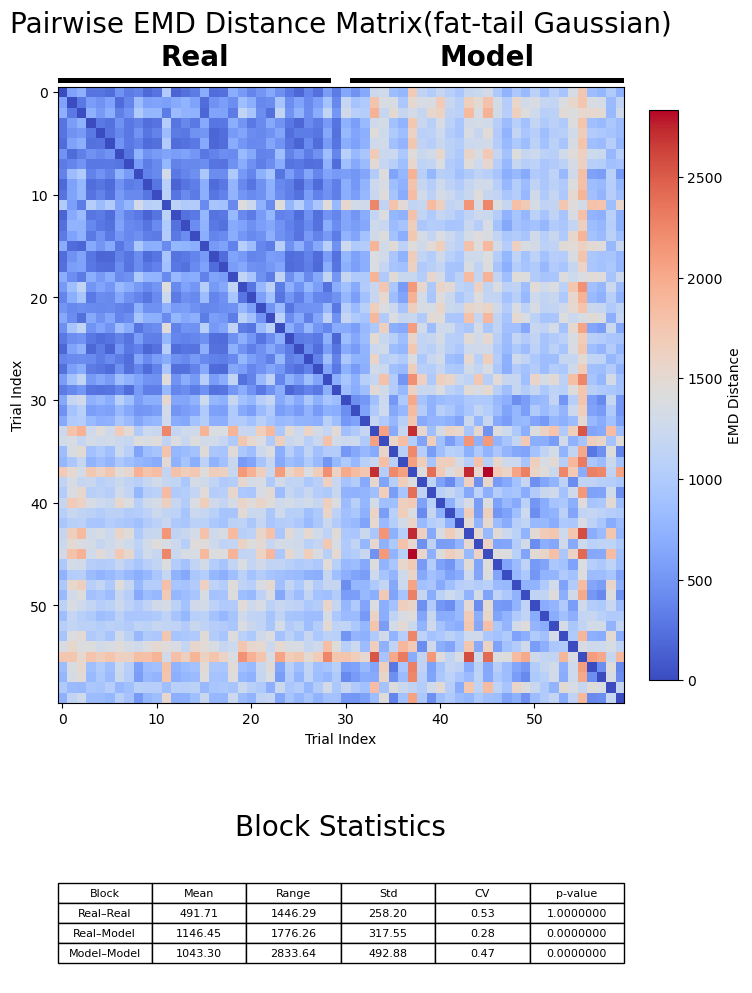

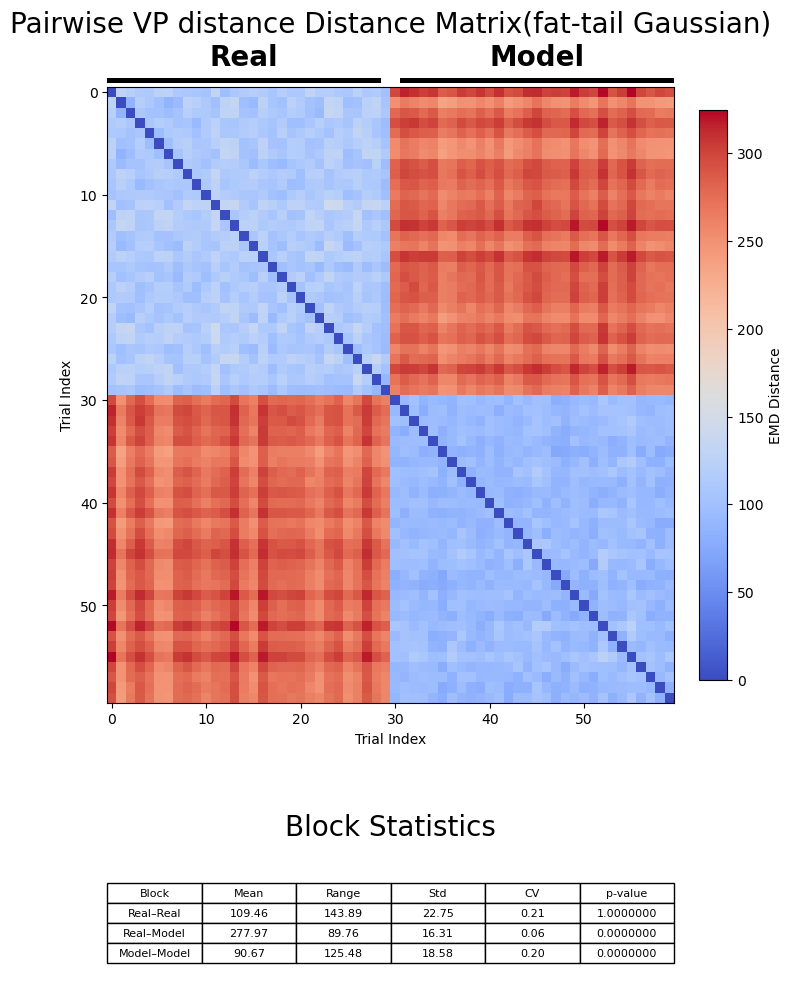

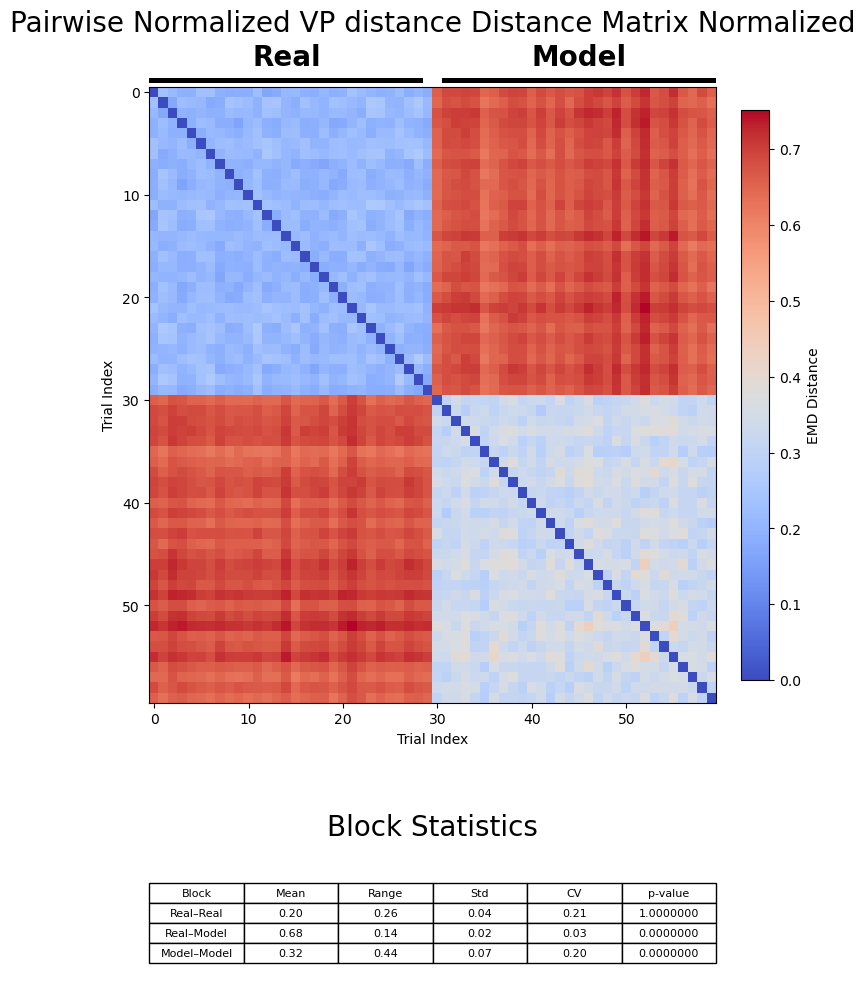

In [17]:
plot_matrixcat_and_stats(emd_matrix, title="Pairwise EMD Distance Matrix(fat-tail Gaussian)", n_real=30, n_model=30, group_size=30)
plot_matrixcat_and_stats(vp_f, title="Pairwise VP distance Distance Matrix(fat-tail Gaussian)", n_real=30, n_model=30, group_size=30)
plot_matrixcat_and_stats(vp_f_norm, title="Pairwise Normalized VP distance Distance Matrix Normalized", n_real=30, n_model=30, group_size=30)
# bar_matrix(emd_matrix, ylabels="Mean EMD distance", title="EMD distance")
# bar_matrix(vp_f, ylabels="Mean VP distance", title="VP distance")
# bar_matrix(vp_f_norm, ylabels="Mean Normalized VP distance", title="Normalized VP distance")

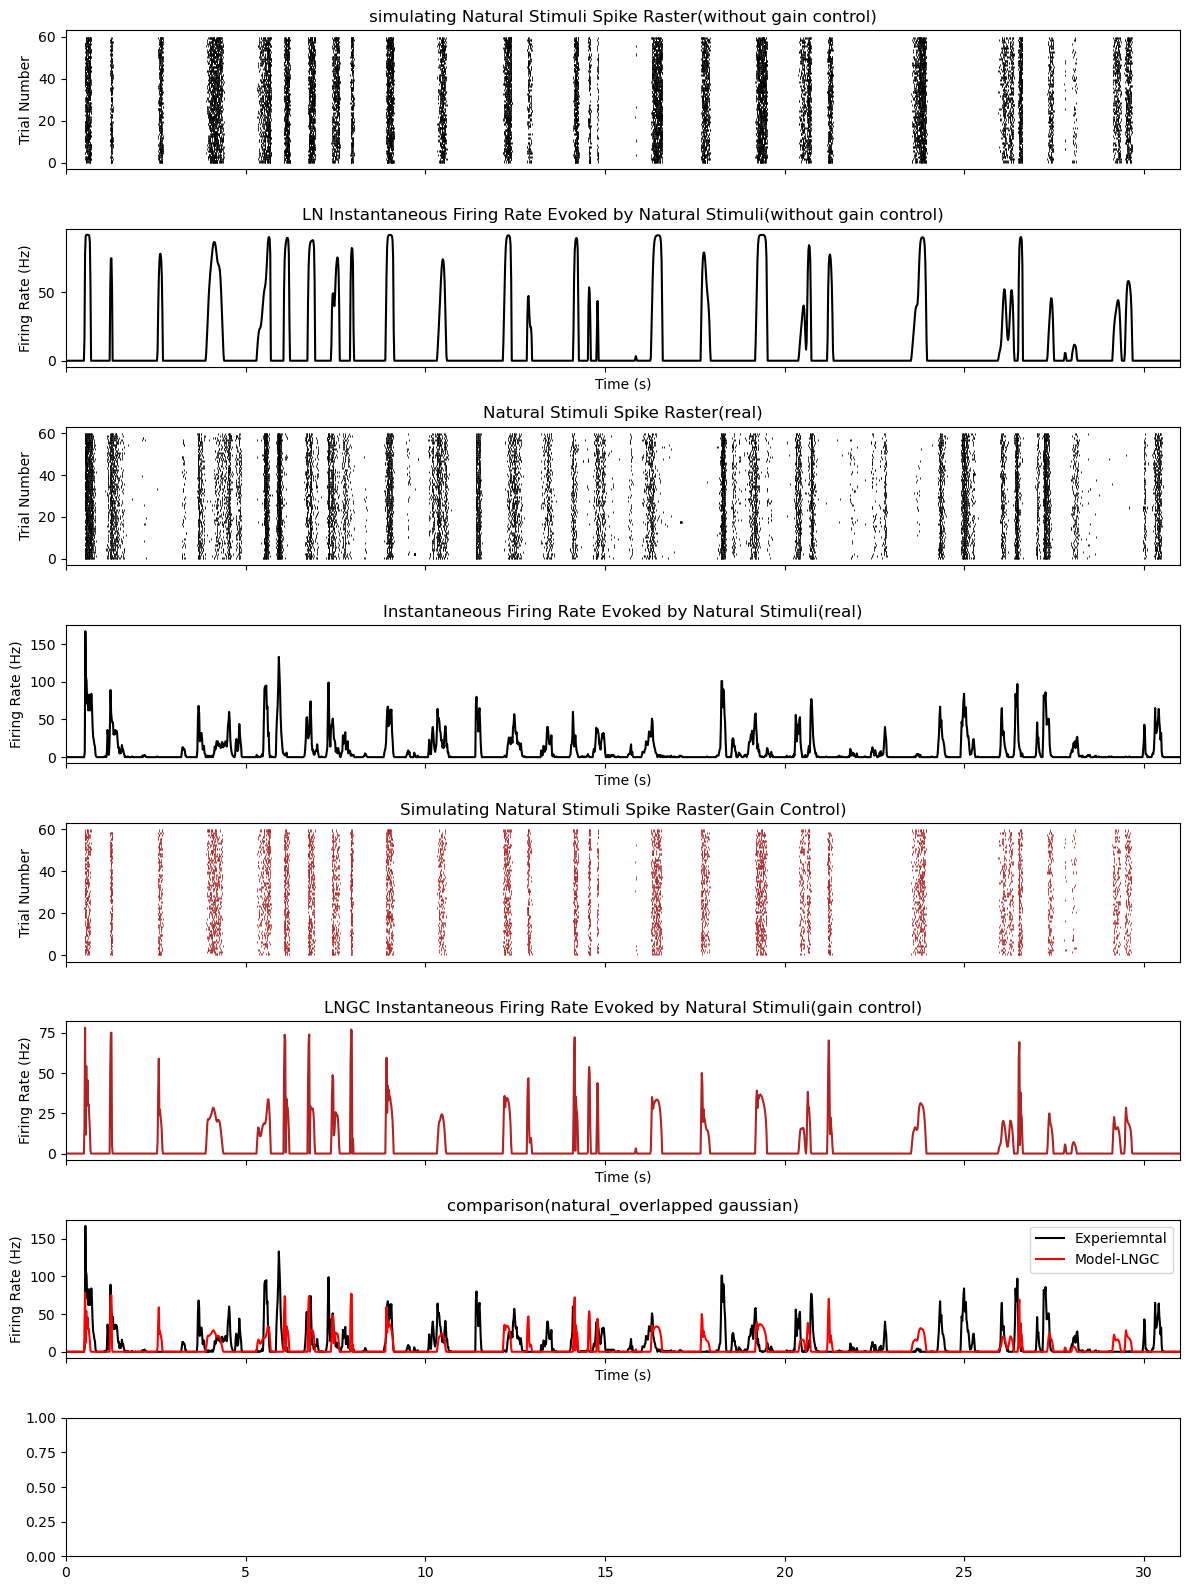

In [18]:
# plot for natural stimuli and gain control stimuli

fig, (ax1, ax2, ax3, ax4, ax5,ax6,ax7,ax8) = plt.subplots(8, 1, figsize=(12, 16), sharex=True)


num_trials_n = len(spike_indices)
spikes_n = []
for spike_idx_n in range(num_trials_n):
    spikes_in_trial = spike_indices[spike_idx_n] / 10000 - delay
    spikes_n.extend(spikes_in_trial)
    
spikes_n = np.array(spikes_n)


num_trials_modeln = len(spike_trainLN)

spikes_modeln = []
for spike_idx_n in range(num_trials_modeln):
    spikes_in_trial = np.array(spike_trainLN[spike_idx_n]) /time_para
    spikes_modeln.extend(spikes_in_trial)
    ax1.vlines(spikes_in_trial, spike_idx_n, spike_idx_n + 1, 'k', linewidth=0.6)

ax1.set_ylabel('Trial Number')
ax1.set_title('simulating Natural Stimuli Spike Raster(without gain control)')
ax1.set_xlim(0, 31)  

ax2.plot(t_sampling/60, LNoutLN, 'k')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Firing Rate (Hz)')
ax2.set_title('LN Instantaneous Firing Rate Evoked by Natural Stimuli(without gain control)')


spikes_modeln = []
for spike_idx_n in range(num_trials_modeln):
    spikes_in_trial = np.array(spike_trainGC[spike_idx_n]) /time_para
    spikes_modeln.extend(spikes_in_trial)
    ax5.vlines(spikes_in_trial, spike_idx_n, spike_idx_n + 1, 'firebrick', linewidth=0.6)

ax5.set_ylabel('Trial Number')
ax5.set_title('Simulating Natural Stimuli Spike Raster(Gain Control)')
ax5.set_xlim(0, 31)  

ax6.plot(t_sampling/60, LNoutGC, 'firebrick')
ax6.set_xlabel('Time (s)')
ax6.set_ylabel('Firing Rate (Hz)')
ax6.set_title('LNGC Instantaneous Firing Rate Evoked by Natural Stimuli(gain control)')

bin_width = 1/60 # s
bins = np.arange(0, 31 + bin_width, bin_width) 
counts_n, bin_edges = np.histogram(spikes_n, bins=bins)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
num_trials_n = len(spike_indices)
spikes_n = []
for spike_idx_n in range(num_trials_n):
    spikes_in_trial = spike_indices[spike_idx_n] / 10000 - delay
    spikes_n.extend(spikes_in_trial)
    ax3.vlines(spikes_in_trial, spike_idx_n, spike_idx_n + 1, 'k', linewidth=0.6)




ax3.set_ylabel('Trial Number')
ax3.set_title('Natural Stimuli Spike Raster(real)')
ax3.set_xlim(0, 31)  

average_spike_count_n = counts_n / num_trials_n
firing_rate_n = average_spike_count_n / bin_width

ax4.plot(bin_centers, firing_rate_n, 'k')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Firing Rate (Hz)')
ax4.set_title('Instantaneous Firing Rate Evoked by Natural Stimuli(real)')

ax7.plot(bin_centers, firing_rate_n, 'k',label='Experiemntal')
ax7.plot(t_sampling/60, LNoutGC, 'r',label='Model-LNGC')
# ax7.plot(t_sampling/60, LNoutLN, 'b',label='Model-LN')
ax7.set_xlabel('Time (s)')
ax7.set_ylabel('Firing Rate (Hz)')
ax7.set_title('comparison(natural_overlapped gaussian)')
ax7.legend()

# # Display parameter summary
# param_text = (
#     f"σ = {sigma_x:.3f} µm;\n "

#     f"B = {B*60000:.3f} / ms;τ = {tau*16.67:.3f} ms;  \n"
#     f"gain = {gain*A:.3f} s; max_rate = {max_rate:.2f} Hz; C = {y/A:.3f} Hz"
# )
# ax8.axis('off')
# ax8.text(12, 0.5, param_text, ha='center', va='center', fontsize=20)



plt.tight_layout()
plt.show()